# Clustering jerárquico

In [2]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
import numpy as np
%matplotlib inline

np.random.seed(4711)

#Generamos dos clusters aleatorios (i.e. que como resultado tendremos 2 clusters) con distribución normal multivariable
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])

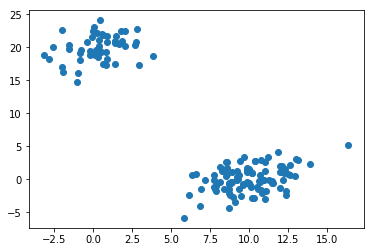

In [3]:
X = np.concatenate([a, b])
plt.scatter(X[:,0], X[:,1])

In [4]:
Z = linkage(X, "ward")

Calculamos el coeficiente de correlación cofenético:<br><br>
Este coeficiente compara las distancias 2 a 2 de las muestras con las del clustering jerarquico.<br>
Cuanto más cercano sea el valor a 1 mejor es el clusterizado ya que preserva las distancias originales.

In [5]:
#Le pasamos la matriz de clusters y las distancias iniciales con pdist y calcula el coeficiente
c, coph_dist = cophenet(Z, pdist(X))
c

0.98001483875742679

### Representación gráfica de un dendrograma

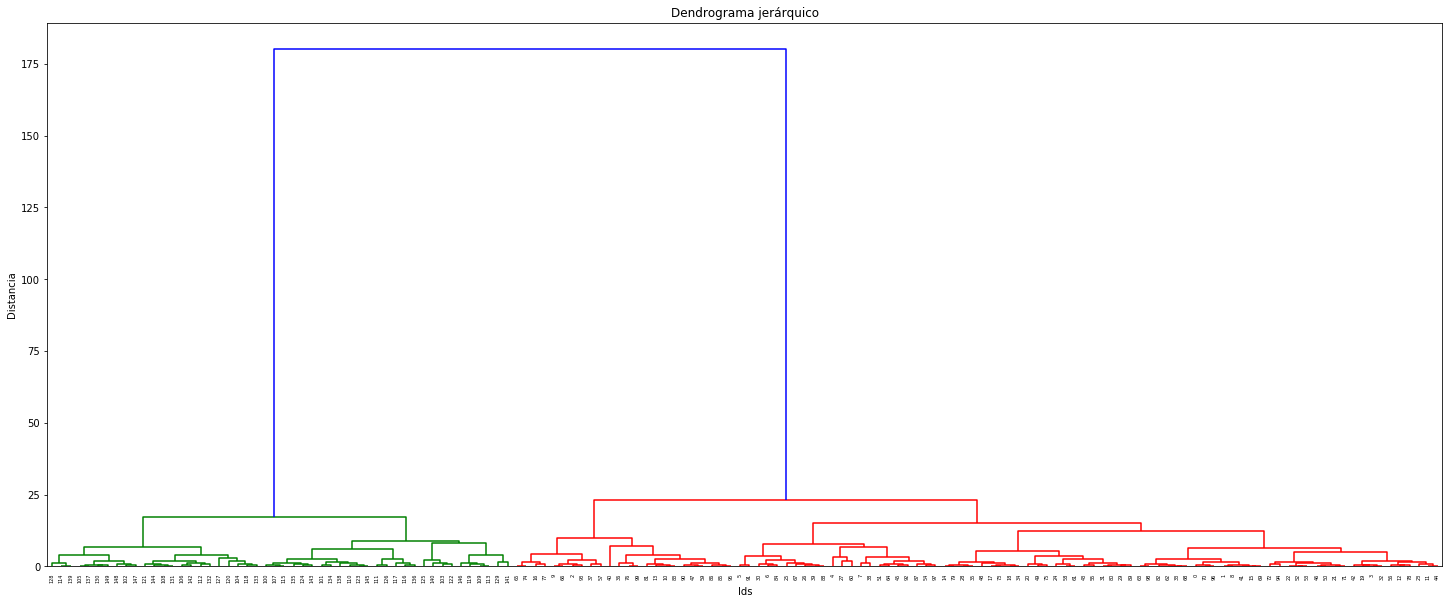

In [6]:
plt.figure(figsize=(25, 10))
plt.title("Dendrograma jerárquico")
plt.xlabel("Ids")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90.)
plt.show()

#### Truncar el dendrograma

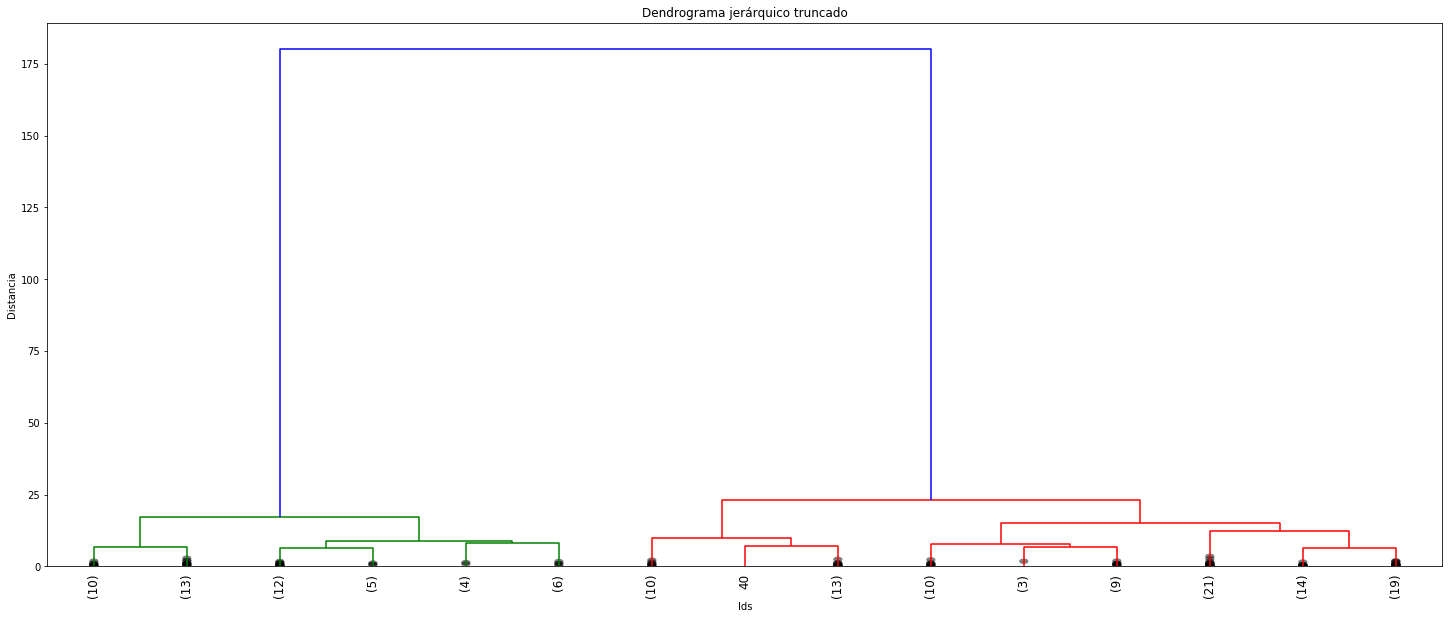

In [7]:
plt.figure(figsize=(25, 10))
plt.title("Dendrograma jerárquico truncado")
plt.xlabel("Ids")
plt.ylabel("Distancia")
#show leaf counts mostraría cuantos elementos hay en esa rama ya unidos
#si sale un indice es porque ese elemento se une en solitario

#show contracted muestra una aglomeración de los puntos y se puede ver a que distancia estan
dendrogram(Z, leaf_rotation=90., truncate_mode="lastp", p=15, show_leaf_counts=True, show_contracted=True)
plt.show()

#### Tunear el dendrograma

Creamos una función que nos diga la distancia de las uniones y en la que podamos poner un corte si queremos

In [8]:
def dendrogram_tune(*args, **kwargs):
    
    max_d=kwargs.pop("max_d", None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    #annotate_above dirá a partir de que distancia muestra las distancias
    annotate_above = kwargs.pop('annotate_above', 0)
    
    ddata = dendrogram(*args,**kwargs)
        
    if not kwargs.get('no_plot', False):
        plt.title("Clustering jerárquico con dendrograma truncado")
        plt.xlabel("Índice del Dataset (o tamaño del cluster)")
        plt.ylabel("Distancia")
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y>annotate_above:
                plt.plot(x,y,'o',c=c)
                plt.annotate('%.3g'%y, (x,y), xytext=(0,-5),
                            textcoords="offset points", va="top", ha="center")
             
    #max_d pinta una raya donde digamos y ademas crea diferentes clusters por debajo
    if max_d:
        plt.axhline(y=max_d, c='k')
        
    return ddata

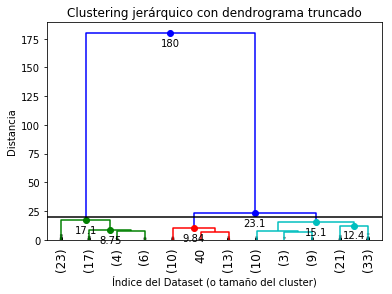

In [9]:
dendrogram_tune(Z,truncate_mode='lastp',p=12, leaf_rotation=90., leaf_font_size=12.,
                show_contracted=True,annotate_above=8.5, max_d=20)
plt.show()

### Determinando el número de clusters apropiado

#### Metodo de la inconsistencia:

$$ Inconsitencia = \frac{altura - mean(alturas)}{std(alturas)} $$

In [20]:
from scipy.cluster.hierarchy import inconsistent

depth = 5 #incluye en la media y el std cada uno de los clusters con los "depth" anteriores
inconsistencia = inconsistent(Z, depth)
inconsistencia[-10:] #media, std, num de links, coef de inconsistencia

array([[  1.80874989,   2.17061644,  10.        ,   2.44276733],
       [  2.31731998,   2.19649179,  16.        ,   2.52742372],
       [  2.24511599,   2.44225327,   9.        ,   2.37659088],
       [  2.30462321,   2.44191287,  21.        ,   2.6387508 ],
       [  2.20673283,   2.68378067,  17.        ,   2.84581581],
       [  1.95309037,   2.58100378,  29.        ,   4.05821033],
       [  3.46173275,   3.53735716,  28.        ,   3.29443647],
       [  3.15857131,   3.54836284,  28.        ,   3.93327935],
       [  4.90210137,   5.10301603,  28.        ,   3.57041559],
       [ 12.12200256,  32.15467931,  30.        ,   5.22936105]])

#### Metodo del codo

Buscamos el mayor codo posible a generar

In [36]:
last = Z[-10:, 2][::-1] #distancias de las ultimas 10 uniones (las invertimos con el -1)
last

array([ 180.27043021,   23.12198936,   17.11527362,   15.11533118,
         12.42734657,    9.84427829,    8.74822275,    8.04935282,
          7.86878542,    7.11106083])

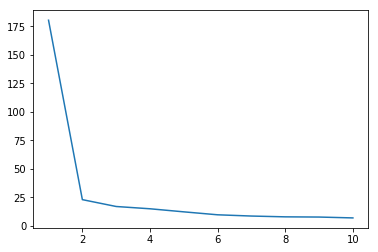

In [40]:
plt.plot(range(1, len(last) + 1), last)

Podemos ver que el codo más agresivo se genera en el paso de 1 a 2 clusters.<br>
También podemos calcular un array de "aceleraciones".

In [45]:
acc = np.diff(last, 2)

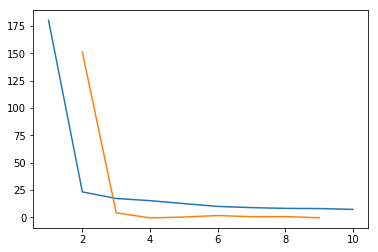

El numero optimo de clusters es 2


In [63]:
plt.plot(range(1, len(last) + 1), last)
plt.plot(range(2, len(last)), acc) #Podemos ver que la aceleración máxima es cuando hay 2 clusters
plt.show()
k = acc.argmax() + 2 #porque hemos empezado en el 2 así que 0 equivaldría a 2
print("El numero optimo de clusters es %i"%k)
#Lo malo de este metodo es que la respuesta nunca podrá ser 1 solo cluster